# Project Proposal: Which is the PULSAR
**DSCI 100 (007-34) Group Project Proposal**  
Group members:
- Elliot Saha
- Alasdair Buchanan
- Sarah Trevisan
- Minghao Li

## 1. Introduction

### 1.1 Background Information
Pulsars are high-magnetized neutron stars that spin at accurately constant speeds (Wikimedia Foundation, 2024). Because of this unique property, they are widely used in scientific research. However, it can be very challenging to identify their signals due to space noises.

### 1.2 Research Question
Our research question is:  
**Which candidate star will be a pulsar? How can we identify a pulsar given its radiation profile?**

### 1.3 Dataset

We will use [HTRU2 dataset](https://archive.ics.uci.edu/dataset/372/htru2) to classify pulsar stars. The dataset contains `Integrated Profile` and `DM-SNR curve` records for pulsar candidates.

- `Integrated profile` is a continuous sequence of measurements that describes the pulse signal received over time.
- `DM-SNR curve` is the curve showing the signal-to-noise ratio between the pulse and background radiation emissions.  
The author of this dataset compressed these arrays into 8 single variables (mean, standard deviation, kurtosis, and skewness for each of these two arrays).

## 2. Data analysis

### 2.1 Data Reading

In [1]:
# import tidyverse, repr, and tidymodels
library(tidyverse)
library(repr)
library(tidymodels)
# set random seed
set.seed(1111)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
pulsar_data <- read_csv("https://raw.githubusercontent.com/Lmh-java/dsci-100-2023w2-group-034/main/data/HTRU_2.csv", col_names=FALSE)
head(pulsar_data)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


### 2.2 Data Wrangling

In [3]:
# rename the columns according to data/Readme.txt
pulsar_data <- pulsar_data |>
    rename(profile_mean = X1,
          profile_sd = X2,
          profile_kurtosis = X3,
          profile_skewness = X4,
          DM_SNR_mean = X5,
          DM_SNR_sd = X6,
          DM_SNR_kurtosis = X7,
          DM_SNR_skewness = X8,
          pulsar_star = X9) |> 
          # mark the label column as a categorical variable
          mutate(pulsar_star = as_factor(pulsar_star)) |>
          # pulsar_star refers to if the row is a pulsar star or not
          mutate(pulsar_star = fct_recode(pulsar_star, "true" = "1", "false" = "0"))

head(pulsar_data)

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,false
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,false
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,false
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,false
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,false
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,false


In [4]:
# We divide the dataset into training and testing subsets. The training set is 70% of the entire dataset, while the testing set takes the other 30%.
pulsar_split <- initial_split(pulsar_data, prop = 0.7, strata = pulsar_star)  
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)
head(pulsar_train)
head(pulsar_test)

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
102.5078,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,false
136.7500,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,false
119.4844,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,false
130.3828,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,false
107.2500,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,false
107.2578,39.49649,0.46588196,1.1628771,4.0794314,24.980418,7.397080,57.78474,false


profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.69964840,3.199833,19.11043,7.975532,74.24222,false
103.01562,39.34165,0.32332837,1.05116443,3.121237,21.74467,7.735822,63.17191,false
88.72656,40.67223,0.60086608,1.12349169,1.178930,11.46872,14.269573,252.56731,false
93.57031,46.69811,0.53190485,0.41672112,1.636288,14.54507,10.621748,131.39400,false
138.17969,51.52448,-0.03185233,0.04679717,6.330268,31.57635,5.155940,26.14331,false
100.85156,51.74352,0.39383679,-0.01124074,2.841137,21.63578,8.302242,71.58437,false


### 2.3 Data Summary

First explore the number of `na` values and the dimension of the training set.

In [5]:
sprintf("Number of NAs: %s", sum(is.na(pulsar_train)))
sprintf("Dimension: %s ", dim_desc(pulsar_train))

[1] "Number of NA: 0"

[1] "Dimension: [12,528 x 9] "

There is no `na` value in the training set, and the dimension of it is 12528 * 9 (8 predictors)

In [6]:
num_observations <- pulsar_train |>
    group_by(pulsar_star) |>
    summarize(num = n())
num_observations

pulsar_star,num
<fct>,<int>
false,11400
true,1128


We can see that in the training set, the category `false` has 11400 observations, while the category `true` only has 1128 observations.

In [7]:
avg_predictors <- pulsar_train |> 
    pivot_longer(profile_mean:DM_SNR_skewness, values_to="value", names_to="variable") |>
    group_by(variable) |>
    summarize(average = mean(value, na.rm=TRUE))
avg_predictors

variable,average
<chr>,<dbl>
DM_SNR_kurtosis,8.2914408
DM_SNR_mean,12.4725362
DM_SNR_sd,26.2517152
DM_SNR_skewness,104.1450850
profile_kurtosis,0.4679873
profile_mean,111.3858407
profile_sd,46.6058129
profile_skewness,1.7283891


Here is a table for the averages of each column.

### 2.4 Visualization


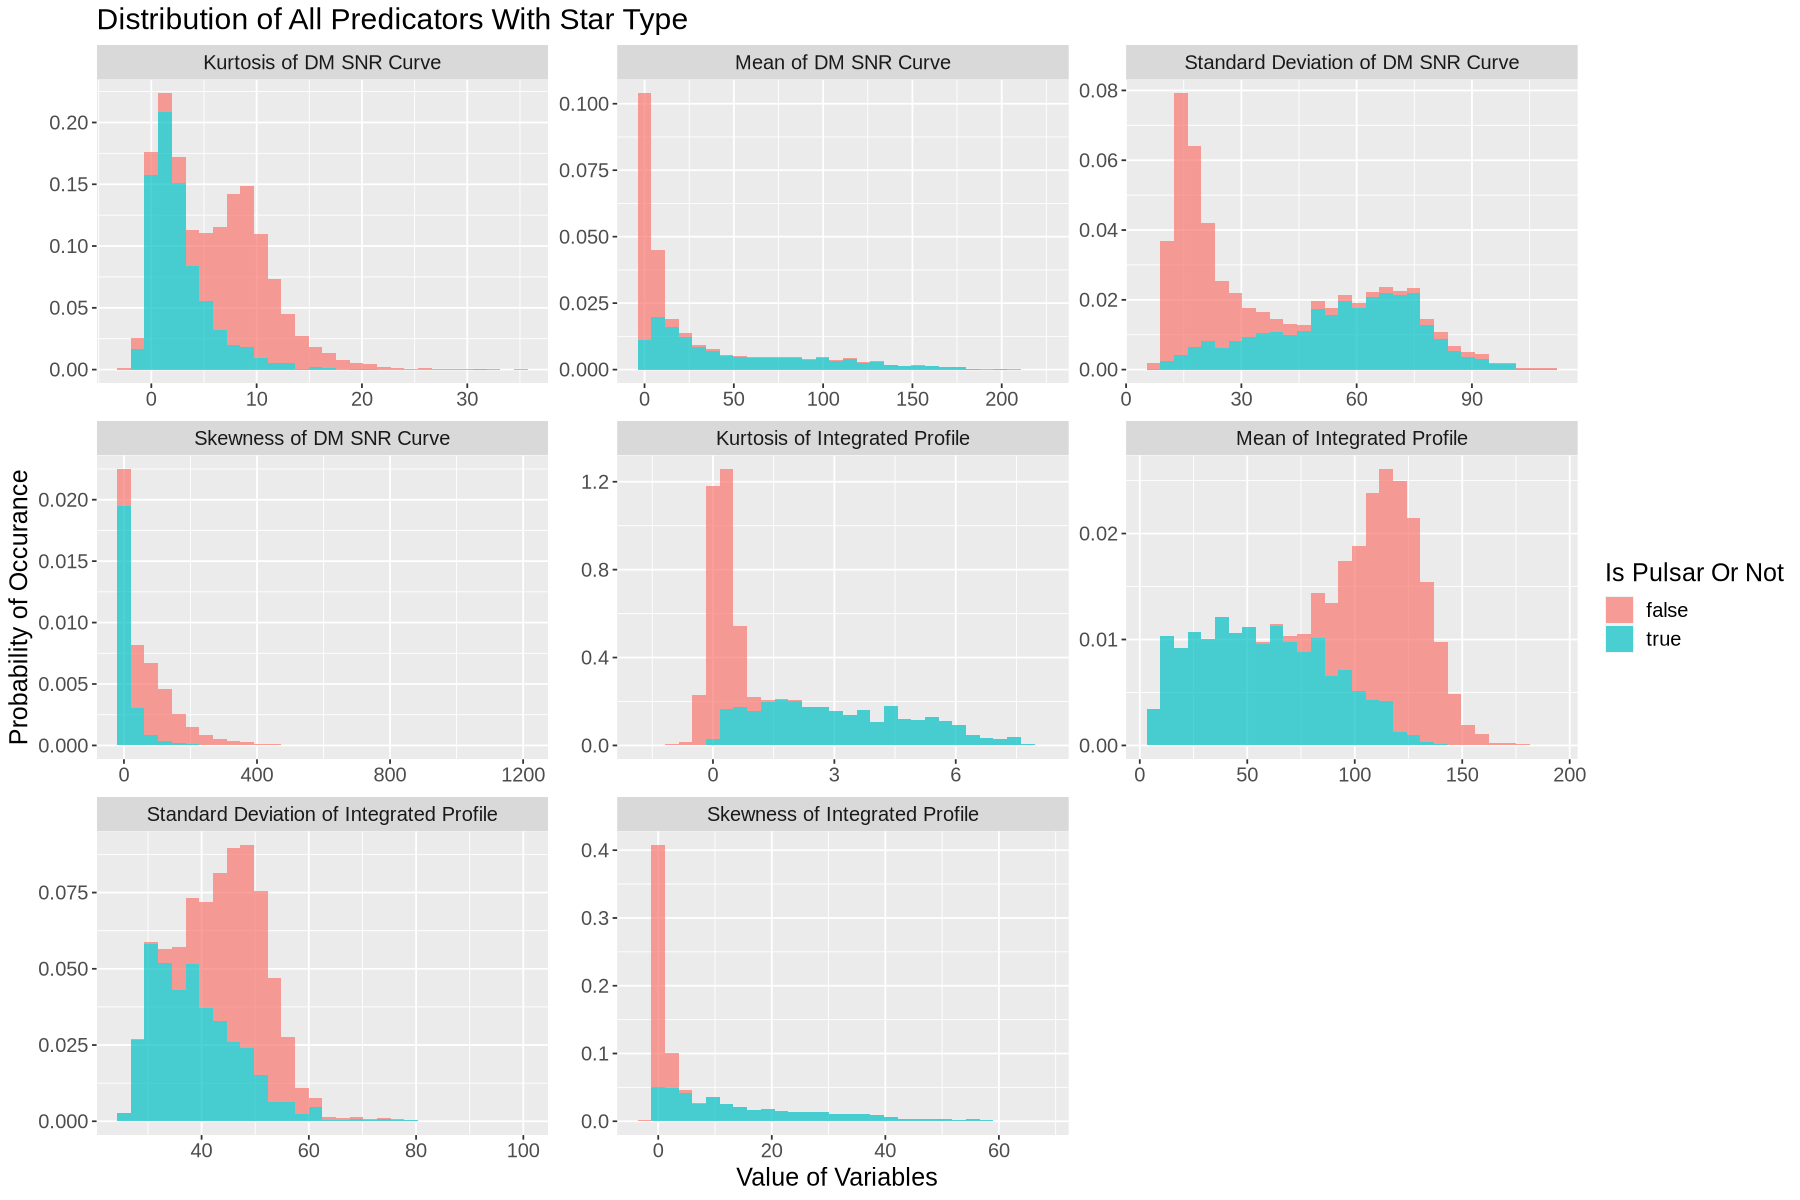

In [8]:
options(repr.plot.width = 15, repr.plot.height=10)

readable_var_names = c("DM_SNR_kurtosis" = "Kurtosis of DM SNR Curve", "DM_SNR_mean" = "Mean of DM SNR Curve", 
                       "DM_SNR_sd" = "Standard Deviation of DM SNR Curve", "DM_SNR_skewness" = "Skewness of DM SNR Curve", "profile_kurtosis" = "Kurtosis of Integrated Profile", 
                       "profile_mean" = "Mean of Integrated Profile", "profile_sd" = "Standard Deviation of Integrated Profile", "profile_skewness" = "Skewness of Integrated Profile")
distribution_plot <- pulsar_train |> 
    pivot_longer(profile_mean:DM_SNR_skewness, values_to="value", names_to="variable") |>
    ggplot(aes(x = value, fill = pulsar_star, y = after_stat(density))) +
    geom_histogram(bins=30, alpha=0.7) +
    facet_wrap(vars(variable), scales = "free", labeller=labeller(variable = readable_var_names)) +
    theme(text = element_text(size=15)) +
    labs(x = "Value of Variables", y = "Probability of Occurance", fill = "Is Pulsar Or Not") +
    ggtitle("Distribution of All Predicators With Star Type")
    
distribution_plot

We visualized the distribution of all 8 predictors, which all of these have different distributions and value ranges.

## 3. Methods

We will perform classifications using the *K-nearest neighbors model*. 
**Important Steps:**
1. Due to category imbalance, we need to resample the training set.
2. Normalize all the predictors to make sure they are equally important to the model.
3. Use 5-fold cross-validation with parameter auto-tuning to automatically search for optimal neighbors to use.
4. Create a model specification and train it.

We plan to use all 8 variables as predictors in the model training process for two reasons:
- These predictors are all strongly relevant to pulsar identification in the astronomical context.
- All of the predictors are quantitative values and display distinct characteristics in distribution.

Finally, we will feed the test set to the model, and visualize the prediction results using a **confusion matrix** to evalute the model.


## 4. Expected outcomes and significance

### 4.1 Expected Outcomes
At the end of this project, we expect to build a model that can predict whether a star is a pulsar based on the mean, skewness, standard deviation, and excess kurtosis of the integrated profile and the DM-SNR curve. We expect the model to have high accuracy and high precision.

### 4.2 Significance
With our model, astronomers can discover more pulsars easily. With more available pulsars, scientists can better test the limits of physics and different theories of gravity with them (Wikimedia Foundation, 2024). This could eventually lead to the discovery of new exoplanets, which could even answer the question of whether external life is present on other planets.

### 4.3 Future Questions
Future studies can be done to investigate what are some other models we can use besides KNN, to better improve the performance.

## 5. Citations
Lyon, R. J., Stappers, B. W., Cooper, S., Brooke, J. M., & Knowles, J. D. (2016). Fifty Years of pulsar candidate selection: From simple filters to a new principled real-time classification approach. Monthly Notices of the Royal Astronomical Society, 459(1), 1104–1123. https://doi.org/10.1093/mnras/stw656 

Wikimedia Foundation. (2024, March 7). Pulsar. Wikipedia. https://en.wikipedia.org/wiki/Pulsar 